In [30]:
import numpy as np
import scipy.stats
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import gif

In [74]:
def generate_dataset(
    num_users=10000,
    baseline_conversion_rate=0.2,
    sessions_skew=0.5, # controls variance in sessions per user. higher = more variance
    beta_size=1000, # controls variance in conversion. higher = less variance
    cvr_decay_factor=0.1,
#     cvr_func=lambda x,y: x
    
):
    sessions = np.exp(scipy.stats.norm(1, sessions_skew).rvs(num_users)).astype(np.int) + 1
    
    cvr_func = lambda x, y: x*(1/10 + 9/10*np.exp(-1*cvr_decay_factor*(y-1)))
    rates = cvr_func(baseline_conversion_rate, sessions)
    a = rates*beta_size
    b = beta_size - rates*beta_size
    conversion_rates = np.random.beta(a, b, size=num_users)

    conversions = np.random.binomial(sessions, conversion_rates, size=num_users)
    return sessions, conversions, conversion_rates

def generate_experiment_datasets(sessions, conversions, num_experiments=5000):
    _sessions_ctrl = []
    _sessions_test = []

    _conversions_ctrl = []
    _conversions_test = []
    
    num_users = sessions.shape[0]

    for x in range(0, num_experiments):
        assignments = np.random.choice(num_users, num_users, replace=False)
        control_idxs = assignments[0:int(num_users/2)]
        test_idxs = assignments[int(num_users/2):]

        _sessions_ctrl.append(sessions[control_idxs])
        _sessions_test.append(sessions[test_idxs])

        _conversions_ctrl.append(conversions[control_idxs])
        _conversions_test.append(conversions[test_idxs])

    sessions_ctrl = np.array(_sessions_ctrl).astype(np.float64)
    sessions_test = np.array(_sessions_test).astype(np.float64)
    conversions_ctrl = np.array(_conversions_ctrl).astype(np.float64)
    conversions_test = np.array(_conversions_test).astype(np.float64)
    
    return sessions_ctrl, sessions_test, conversions_ctrl, conversions_test

def get_bootstrapped_null_hypothesis_distribution(sessions, conversions, num_bootstraps=5000):
    num_users = sessions.shape[0]
    
    bs_observed_diffs = []
    for x in range(0, num_bootstraps):

        assignments = np.random.choice(num_users, num_users, replace=True)
        ctrl_idxs = assignments[0:int(num_users/2)]
        test_idxs = assignments[int(num_users/2):]

        bs_sessions_ctrl = sessions[ctrl_idxs]
        bs_sessions_test = sessions[test_idxs]
        bs_orders_ctrl = conversions[ctrl_idxs]
        bs_orders_test = conversions[test_idxs]

        bs_observed_diffs.append(
            bs_orders_test.sum()/bs_sessions_test.sum()
            -
            bs_orders_ctrl.sum()/bs_sessions_ctrl.sum()
        )
    return np.array(bs_observed_diffs)

def bootstrapped_p_values(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test, null_dist):
    observed_diffs = (
        conversions_test.sum(axis=1)/sessions_test.sum(axis=1)
        -
        conversions_ctrl.sum(axis=1)/sessions_ctrl.sum(axis=1)
    )
    
    return 2*(1 - (np.abs(observed_diffs) > null_dist.reshape(-1, 1)).sum(axis=0) / null_dist.shape[0])
    
def binomial_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test):
    total_sessions_ctrl = sessions_ctrl.sum(axis=1)
    total_sessions_test = sessions_test.sum(axis=1)
    total_conversions_ctrl = conversions_ctrl.sum(axis=1)
    total_conversions_test = conversions_test.sum(axis=1)
    
    
    cvrs_ctrl = total_conversions_ctrl/total_sessions_ctrl
    cvrs_test = total_conversions_test/total_sessions_test
    
    pooled_ctrs = (
        (total_conversions_ctrl + total_conversions_test) /
        (total_sessions_ctrl + total_sessions_test)
    )
    variances = pooled_ctrs * (1 - pooled_ctrs) * (1 / total_sessions_ctrl + 1 / total_sessions_test)
    z_scores = np.abs(cvrs_test - cvrs_ctrl) / np.sqrt(variances)
    p_values = 2*(1 - scipy.stats.norm(loc=0, scale=1).cdf(z_scores))
    return p_values


def delta_method_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test):
    num_users = sessions_ctrl.shape[1]

    mean_sessions_ctrl = sessions_ctrl.mean(axis=1)
    mean_conversions_ctrl = conversions_ctrl.mean(axis=1)
    var_sessions_ctrl = sessions_ctrl.var(axis=1)
    var_conversions_ctrl = conversions_ctrl.var(axis=1)

    mean_sessions_test = sessions_test.mean(axis=1)
    mean_conversions_test = conversions_test.mean(axis=1)
    var_sessions_test = sessions_test.var(axis=1)
    var_conversions_test = conversions_test.var(axis=1)

    cov_ctrl = (
        (conversions_ctrl - mean_conversions_ctrl.reshape(-1, 1)) * (sessions_ctrl - mean_sessions_ctrl.reshape(-1, 1))
    ).mean(axis=1)
    cov_test = (
        (conversions_test - mean_conversions_test.reshape(-1, 1)) * (sessions_test - mean_sessions_test.reshape(-1, 1))
    ).mean(axis=1)

    var_ctrl = (
        var_conversions_ctrl / mean_sessions_ctrl ** 2 + 
        var_sessions_ctrl * mean_conversions_ctrl ** 2 / mean_sessions_ctrl ** 4 -
        2 * mean_conversions_ctrl / mean_sessions_ctrl ** 3 * cov_ctrl
    )
    var_test = (
        var_conversions_test / mean_sessions_test ** 2 + 
        var_sessions_test * mean_conversions_test ** 2 / mean_sessions_test ** 4 - 
        2 * mean_conversions_test / mean_sessions_test ** 3 * cov_test
    )

    cvrs_ctrl = conversions_ctrl.sum(axis=1) / sessions_ctrl.sum(axis=1)
    cvrs_test = conversions_test.sum(axis=1) / sessions_test.sum(axis=1)
    
    z_scores = np.abs(cvrs_test - cvrs_ctrl) / np.sqrt(var_ctrl / num_users + var_test / num_users)
    p_values = 2*(1 - scipy.stats.norm(loc = 0, scale = 1).cdf(z_scores))
    return p_values

In [119]:
sessions, conversions, conversion_rates = generate_dataset(
    num_users=10000,
    sessions_skew=2.5,
#     cvr_func=lambda x,y: x*(1/10 + 9/10*np.exp(-0.05*(y-1)))
    cvr_decay_factor=0
    
)

sessions_ctrl, sessions_test, conversions_ctrl, conversions_test = generate_experiment_datasets(
    sessions, 
    conversions, 
    num_experiments=5000
)

In [123]:
# run all tests
bootstrapped_null_dist = get_bootstrapped_null_hypothesis_distribution(
    sessions=np.append(sessions_ctrl[0], sessions_test[0]),
    conversions=np.append(conversions_ctrl[0], conversions_test[0]), 
    num_bootstraps=10000
)

bs_p_values = bootstrapped_p_values(
    sessions_ctrl, conversions_ctrl, sessions_test, conversions_test, bootstrapped_null_dist
)

binom_p_values = binomial_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test)
delta_p_values = delta_method_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test)

In [177]:
@gif.frame
def plot(sessions, conversion_rates, binom_p_values, delta_p_values, bs_p_values, cvr_decay_factor, plot_all=True):
    fig = plt.figure(constrained_layout=True, figsize=(15, 10), dpi=200)
    gs = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(gs[0:2, :2])
    ax0.set_title('Sessions per user distribution');
    ax0.get_yaxis().set_visible(False);
    ax0.set_xlabel('Sessions per user');
    ax0.hist(sessions[sessions<= min(100, np.max(sessions))], density=True, bins=100);
    ax0.set_xlim(0, min(100, np.max(sessions)));

    textstr = '\n'.join((
        r'$p_{50}=%.2f$' % np.percentile(sessions, 50),
        r'$p_{90}=%.2f$' % np.percentile(sessions, 90),
        r'$p_{99}=%.2f$' % np.percentile(sessions, 99),
    ))
    props = dict(boxstyle='round', alpha=0.5, facecolor=None)
    ax0.text(0.80, 0.95, textstr, transform=ax0.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)



    ax1 = fig.add_subplot(gs[0:2, 2:])
    df = pd.DataFrame({'spu': sessions, 'cv': conversion_rates})
    gdf = df.groupby('spu').cv.mean().reset_index(name='mean_cv')
    ax1.set_title('Session conversion rate');
    ax1.plot(gdf[gdf.spu <= 50].spu, gdf[gdf.spu <= 50].mean_cv);
    ax1.set_xlabel('Sessions per user');
    ax1.set_ylabel('Sessions conversion rate');
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1));
    ax1.set_ylim(0, 0.3);

    textstr = r'$CVR_{base}(\frac{1}{10} + \frac{9}{10}e^{-%.2f*(num\_sessions-1)})$' % (cvr_decay_factor)
    props = dict(boxstyle='round', alpha=0.5, facecolor=None)
    ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    
    if plot_all:
        ax2 = fig.add_subplot(gs[2, :-2]);
        ax2.set_title('Binomial z-test p-values');
        ax2.hist(binom_p_values, bins=100, color='r');
        ax2.axes.get_yaxis().set_visible(False);

        ax3 = fig.add_subplot(gs[3, :-2])
        ax3.set_title('Delta method p-values');
        ax3.hist(delta_p_values, bins=100, color='g');
        ax3.axes.get_yaxis().set_visible(False);

        ax4 = fig.add_subplot(gs[4, :-2])
        ax4.set_title('Bootstrapped p-values');
        ax4.hist(bs_p_values, bins=100, color='b');
        ax4.axes.get_yaxis().set_visible(False);
    else:
        ax2 = fig.add_subplot(gs[2:, :-2]);
        ax2.set_title('Binomial z-test p-values');
        ax2.hist(binom_p_values, bins=100, color='r');
        ax2.axes.get_yaxis().set_visible(False);


    def get_cdf_x_y(p_values):
        return sorted(p_values), np.arange(len(p_values)) / len(p_values)

    ax5 = fig.add_subplot(gs[2::, 2:]);
    bn_x, bn_y = get_cdf_x_y(binom_p_values)
    ax5.plot(bn_x, bn_y, color='r', label=f'binomial z-test (KS p-value: {scipy.stats.kstest(binom_p_values, scipy.stats.uniform(loc=0, scale=1).cdf).pvalue:0.2f})');
    
    if plot_all:        
        bs_x, bs_y = get_cdf_x_y(bs_p_values)
        ax5.plot(bs_x, bs_y, color='b', label=f'bootstrapped (KS p-value: {scipy.stats.kstest(bs_p_values, scipy.stats.uniform(loc=0, scale=1).cdf).pvalue:0.2f})');

        delta_x, delta_y = get_cdf_x_y(delta_p_values)
        ax5.plot(delta_x, delta_y, color='g', label=f'delta method (KS p-value: {scipy.stats.kstest(delta_p_values, scipy.stats.uniform(loc=0, scale=1).cdf).pvalue:0.2f})');


    ax5.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), color='k', label='expected');
    ax5.legend();
    ax5.set_title('CDF p-values');
#     plt.close();
#     return fig

In [179]:
frame = plot(sessions, conversion_rates, binom_p_values, delta_p_values, bs_p_values, 0, plot_all=False);
# frame

In [182]:
frames = []
frames_all = []

sessions_skew=0.9
num_users = 50000
num_experiments = 10000
# num_users = 10000
# num_experiments = 5000
baseline_conversion_rate = 0.2
cvr_decay_factor = 0
beta_size = 1000

# for sessions_skew in np.linspace(0.25, 2.5, 10):
for cvr_decay_factor in np.linspace(0.0, 0.1, 10):
    print(f"Iteration with sessions_skew: {sessions_skew}, cvr_decay_factor: {cvr_decay_factor}")
    sessions, conversions, conversion_rates = generate_dataset(
        num_users=num_users,
        baseline_conversion_rate=baseline_conversion_rate,
        sessions_skew=sessions_skew,
        cvr_decay_factor=cvr_decay_factor,
        beta_size=beta_size
    )

    sessions_ctrl, sessions_test, conversions_ctrl, conversions_test = generate_experiment_datasets(
        sessions, 
        conversions, 
        num_experiments=num_experiments
    )

    # run all tests
    bootstrapped_null_dist = get_bootstrapped_null_hypothesis_distribution(
        sessions=np.append(sessions_ctrl[0], sessions_test[0]),
        conversions=np.append(conversions_ctrl[0], conversions_test[0]), 
        num_bootstraps=10000
    )

    bs_p_values = bootstrapped_p_values(
        sessions_ctrl, conversions_ctrl, sessions_test, conversions_test, bootstrapped_null_dist
    )

    binom_p_values = binomial_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test)
    delta_p_values = delta_method_z_test(sessions_ctrl, conversions_ctrl, sessions_test, conversions_test)


    frame = plot(sessions, conversion_rates, binom_p_values, delta_p_values, bs_p_values, cvr_decay_factor, plot_all=False)
    frames.append(frame)
    
    frame = plot(sessions, conversion_rates, binom_p_values, delta_p_values, bs_p_values, cvr_decay_factor, plot_all=True)
    frames_all.append(frame)

Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.0
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.011111111111111112
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.022222222222222223
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.03333333333333333
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.044444444444444446
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.05555555555555556
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.06666666666666667
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.07777777777777778
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.08888888888888889
Iteration with sessions_skew: 0.9, cvr_decay_factor: 0.1


In [183]:
# gif.save(frames, "p_values_session_skew.gif", duration=1000, unit='ms')
# gif.save(frames_all, "p_values_session_skew_all.gif", duration=1000, unit='ms')

gif.save(frames, "p_values_cvr_decay_factor.gif", duration=1000, unit='ms')
gif.save(frames_all, "p_values_cvr_decay_factor_all.gif", duration=1000, unit='ms')

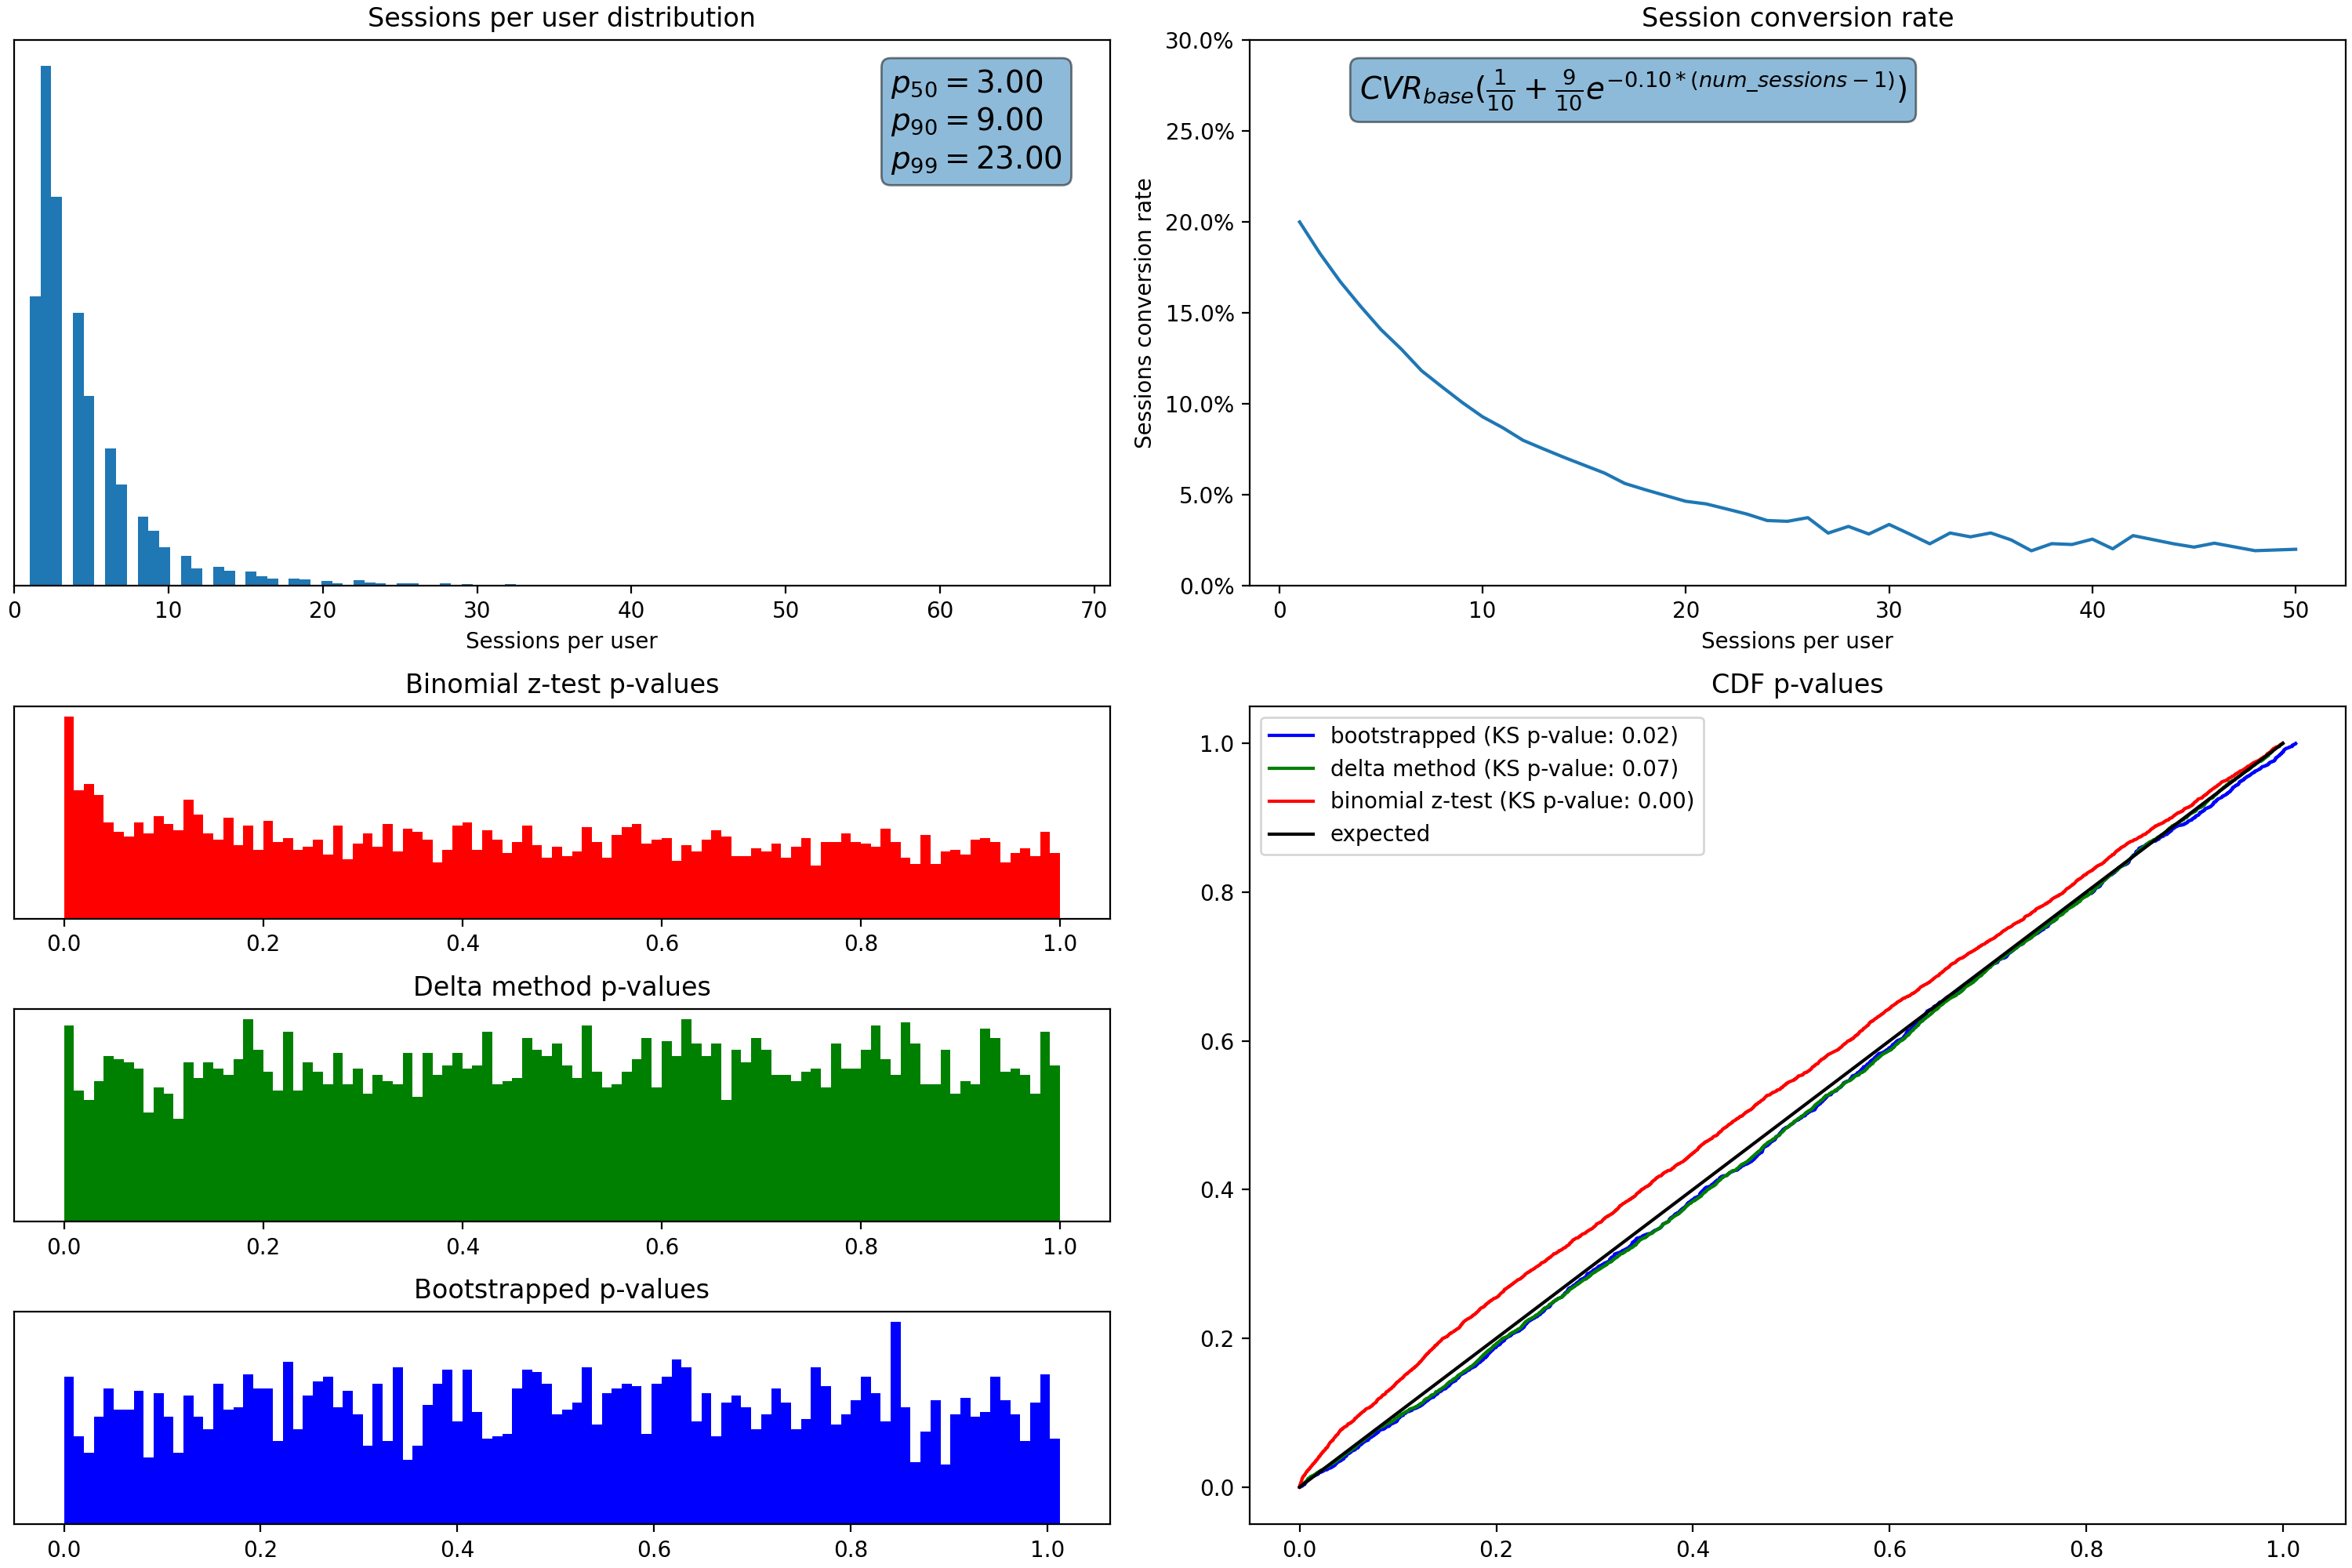

In [173]:
frames[-1]